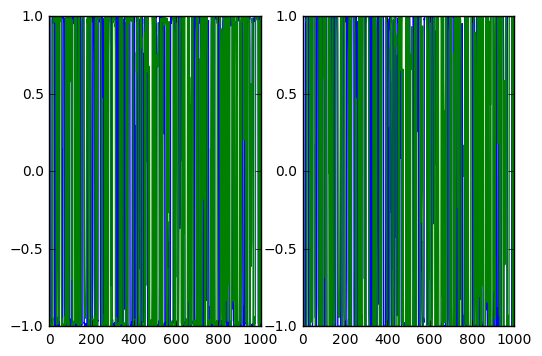

3037799 Episode 3040 rsum: -18 sigma: 0.023970108608


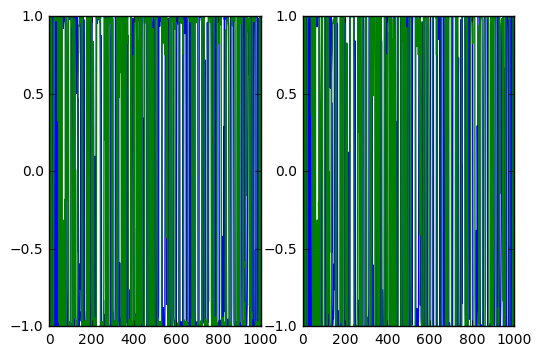

3038799 Episode 3041 rsum: -32 sigma: 0.0239461504685


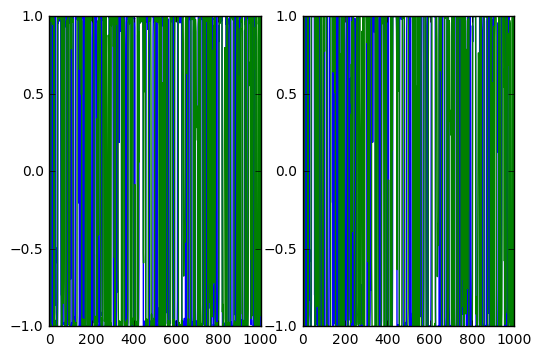

3039799 Episode 3042 rsum: -36 sigma: 0.0239222162752


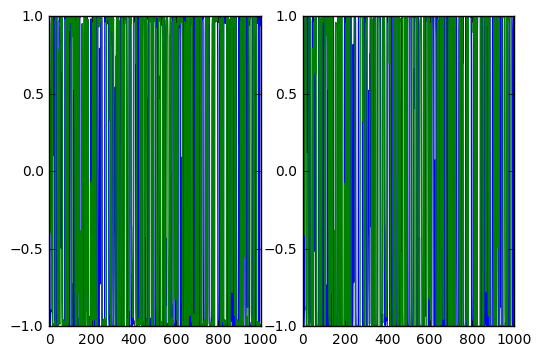

3040799 Episode 3043 rsum: -35 sigma: 0.0238983060041


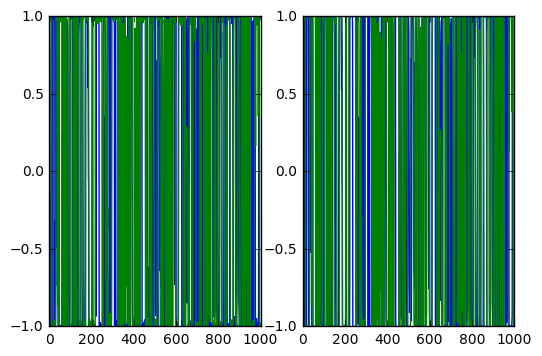

3041799 Episode 3044 rsum: -28 sigma: 0.0238744196313


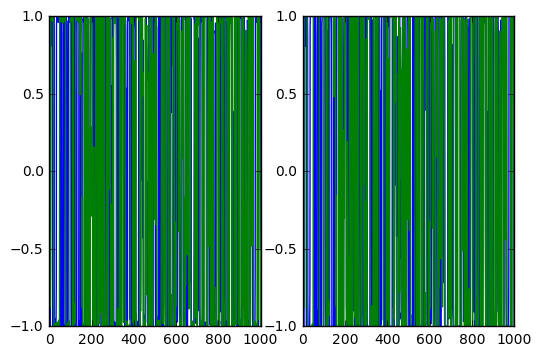

3042799 Episode 3045 rsum: -40 sigma: 0.023850557133


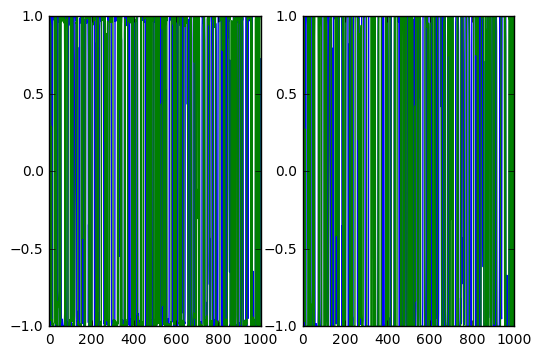

3043799 Episode 3046 rsum: -29 sigma: 0.0238267184852


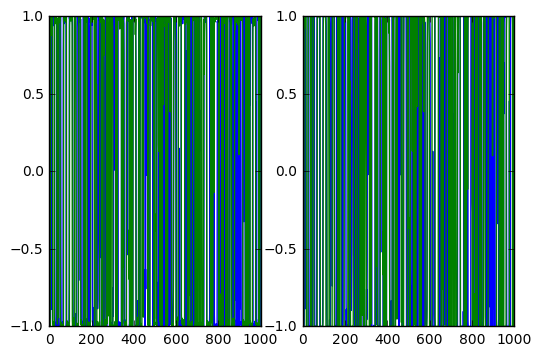

3044799 Episode 3047 rsum: -42 sigma: 0.0238029036642


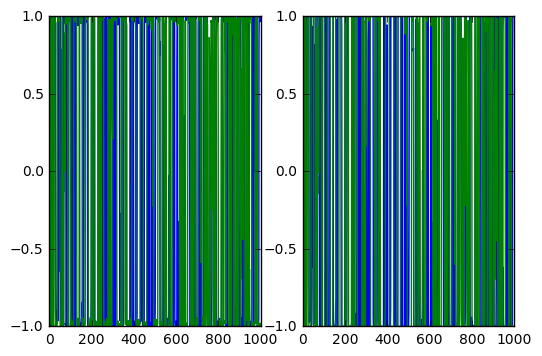

3045799 Episode 3048 rsum: -50 sigma: 0.0237791126462


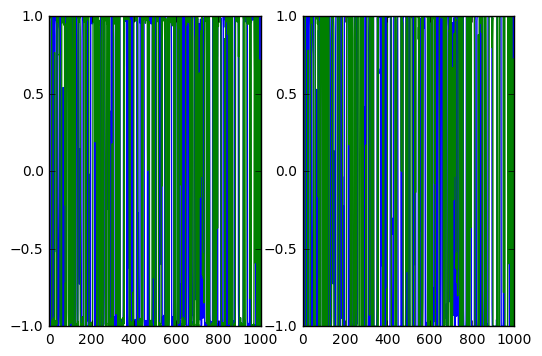

3046799 Episode 3049 rsum: -41 sigma: 0.0237553454072


KeyboardInterrupt: 

In [2]:
# Continuous Obstacle Avoidance with DDPG network

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from MazeEnv_Continuous import MazeSimulator
from DDPG_Agent import DDPG_Agent
import gym
import random
from IPython.display import clear_output

settings = {
    'objects': [
        'friend',
        'enemy',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'obstacle': -1,
        'wall': -1,
    },
    'hero_bounces_off_walls': False,
    'enemy_move':True,
    'world_size': (500,500),
    'hero_initial_position': [250, 250],
    'hero_initial_speed':    [0,   0],
    'end_position':          [750, 450],
    "maximum_speed":         [10, 10],
    "enemy_max_speed":       [50, 50],
    'max_angular_speed':1,
    'max_line_speed':50,
    'max_line_acc':200,
    "object_radius": 15.0,
    "hero_radius": 10,
    "num_objects": {
        "friend" : 0,
        "enemy" :  20,
    },
    "num_observation_lines" : 200,
    'num_action':2,
    'num_state':200,
    "observation_line_length": 200,
    "laser_buffer_length":1,
    "obstacle_tolerance":0.5,
    "delta_v": 50,
    "sim_dt":0.1,
    'DDPG':{
        'net_structure':'NORMAL'
        'learning_rate_A':0.0001,
        'learning_rate_C':0.001,
        'gamma':0.99,
        'batch_size':32,
        'replay_buffer_size':1000000,
        'soft_update_rate':0.001,
        'USECONV':False,
        'num_conv1':32,
        'num_conv2':64,
        'num_fc1':512,
        'num_fc2':128,
    }
}

sim = MazeSimulator(settings)
tf.reset_default_graph()
sess = tf.Session()
agent = DDPG_Agent(settings, sess)
MaxEpisode = 50000
MaxStep = 1000
sigma = 0.5
trainsteps = 0
rlog = []
for episode in range(MaxEpisode):
    sim = MazeSimulator(settings)
    s = sim.observe()
    rsum = 0
    a1log=[]
    a2log=[]
    a1rawlog=[]
    a2rawlog=[]
    losslog = []
    for step in range(MaxStep):
        action = sess.run(agent.A, feed_dict={agent.S:[s]})[0]
        
        a1rawlog.append(action[0])
        a2rawlog.append(action[1])
        
        a0 = np.clip(np.random.normal(action[0], sigma), -1, 1)
        a1 = np.clip(np.random.normal(action[1], sigma), -1, 1)
        
        a1log.append(a0)
        a2log.append(a1)
        
        action = [float(a0), float(a1)]
        s1, r, d = sim.step(*action)
        agent.buffer_add(s, action, r, s1, d)
        rsum += r
        # train
        if agent.buffer_ready:
            loss = agent.train_it()
            losslog.append(loss)
            trainsteps += 1
            sigma *= 0.999999
        s = s1
        #sim.draw([action, r])
        if d: break
        
    # End of Episode
    rlog.append(rsum)
    if episode % 10 == 0:
        clear_output()
        
    if episode % 100 == 0:
        plt.plot(rlog)
        plt.show()
    plt.subplot(1,2,1)
    plt.plot(a1log)
    plt.plot(a2log)
    plt.subplot(1,2,2)
    plt.plot(a1rawlog)
    plt.plot(a2rawlog)
    plt.show()
    if agent.buffer_ready:
        print trainsteps, 'Episode', episode, 'rsum:', rsum, 'sigma:', sigma
    else:
        print trainsteps, 'Episode', episode, 'rsum:', rsum, 'lenbuff', len(agent.exp_buffer)


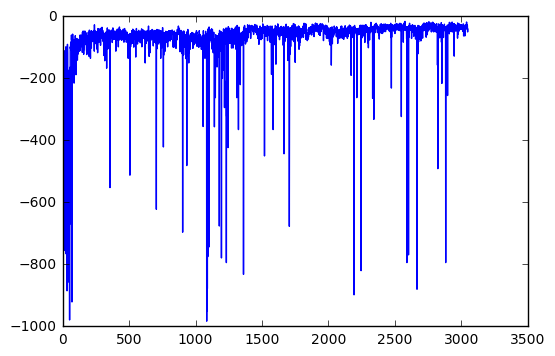

In [3]:
plt.plot(rlog)
plt.show()

In [7]:

settings = {
    'objects': [
        'friend',
        'enemy',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'obstacle': -1,
        'wall': -1,
    },
    'hero_bounces_off_walls': False,
    'enemy_move':True,
    'world_size': (500,500),
    'hero_initial_position': [250, 250],
    'hero_initial_speed':    [0,   0],
    'end_position':          [750, 450],
    "maximum_speed":         [10, 10],
    "enemy_max_speed":       [10, 10],
    'max_angular_speed':1,
    'max_line_speed':50,
    'max_line_acc':200,
    "object_radius": 15.0,
    "hero_radius": 10,
    "num_objects": {
        "friend" : 0,
        "enemy" :  10,
    },
    "num_observation_lines" : 200,
    'num_action':2,
    'num_state':200,
    "observation_line_length": 200,
    "laser_buffer_length":1,
    "obstacle_tolerance":0.5,
    "delta_v": 50,
    "sim_dt":0.1,
    'DDPG':{
        'net_structure':'NORMAL',
        'learning_rate_A':0.0001,
        'learning_rate_C':0.001,
        'gamma':0.99,
        'batch_size':32,
        'replay_buffer_size':1000000,
        'soft_update_rate':0.001,
        'USECONV':False,
        'num_conv1':32,
        'num_conv2':64,
        'num_fc1':512,
        'num_fc2':128,
    }
}
demo_episode = 10
demo_step = 500
for episode in range(demo_episode):
    sim = MazeSimulator(settings)
    s = sim.observe()
    rsum = 0
    for step in range(demo_step):
        action = sess.run(agent.A, feed_dict={agent.S:[s]})[0]
        a0 = np.clip(np.random.normal(action[0], sigma), -1, 1)
        a1 = np.clip(np.random.normal(action[1], sigma), -1, 1)
        s1, r, d = sim.step(float(a0), float(a1))
        sim.draw([action,r])
        s = s1
        if d: break

KeyboardInterrupt: 

In [ ]:
s-0.5